# Forecasting with Chronos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/stable/docs/tutorials/timeseries/forecasting-chronos.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/stable/docs/tutorials/timeseries/forecasting-chronos.ipynb)


AutoGluon-TimeSeries (AG-TS) includes [Chronos](https://github.com/amazon-science/chronos-forecasting) family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

AG-TS provides a robust and easy way to use Chronos through the familiar `TimeSeriesPredictor` API. This tutorial describes how to
- Use Chronos models in **zero-shot** mode to make forecasts without any dataset-specific training
- **Fine-tune** Chronos models on custom data to improve the accuracy
- Handle **covariates & static features** by combining Chronos with a tabular regression model

:::{note}

**New in v1.2:** AutoGluon now features Chronos-Bolt⚡️ — new, more accurate, and up to 250x faster Chronos models.

:::

In [1]:
# # We use uv for faster installation
# !pip install uv
# !uv pip install -q autogluon.timeseries --system
# !uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

## Getting started with Chronos

Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS.
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference.

AutoGluon supports both the original Chronos models (e.g., [`chronos-t5-large`](https://huggingface.co/autogluon/chronos-t5-large)), as well as the new, more accurate and up to 250x faster Chronos-Bolt⚡ models (e.g., [`chronos-bolt-base`](https://huggingface.co/autogluon/chronos-bolt-base)).

The easiest way to get started with Chronos is through the model-specific presets.

- **(recommended)** The new, fast Chronos-Bolt️ models can be accessed using the `"bolt_tiny"`, `"bolt_mini"`, `"bolt_small"` and `"bolt_base"` presets.
- The original Chronos models can be accessed using the `"chronos_tiny"`, `"chronos_mini"`, `"chronos_small"`, `"chronos_base"` and `"chronos_large"` presets.

Note that the original Chronos models of size `small` and above require a GPU to run, while all Chronos-Bolt models can be run both on a CPU and a GPU.

Alternatively, Chronos can be combined with other time series models using presets `"medium_quality"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

## Zero-shot forecasting

Let's work with a subset of the [Australian Electricity Demand dataset](https://zenodo.org/records/4659727) to see Chronos-Bolt in action.

First, we load the dataset as a [TimeSeriesDataFrame](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesDataFrame.html).

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/sjsj/Documents/order-platform-mlops/order-platform-msa-train-pipeline/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
# Create TimeSeriesDataFrame

# Load data
df = pd.read_csv(
    "/Users/sjsj/Documents/order-platform-mlops/order-platform-msa-train-pipeline/data/forecast_data_featured.csv"
)

# Optional: Sort by item_id and timestamp for optimal performance
# (TimeSeriesDataFrame can handle both orders, but this is more efficient)
df = df.rename(columns={"store_id": "item_id"})
df = df.rename(columns={"order_count": "target"})

df = df.sort_values(["item_id", "timestamp"])

# Create TimeSeriesDataFrame
data = TimeSeriesDataFrame.from_data_frame(df)
data.head()

category region  target  sales_amount  \
item_id   timestamp                                                          
store_001 2022-01-01 00:00:00  디저트/케이크/생크림케이크    광진구      15         30008   
          2022-01-01 01:00:00  디저트/케이크/생크림케이크    광진구      11         22542   
          2022-01-01 02:00:00  디저트/케이크/생크림케이크    광진구      20         53162   
          2022-01-01 03:00:00  디저트/케이크/생크림케이크    광진구       1          2765   
          2022-01-01 04:00:00  디저트/케이크/생크림케이크    광진구       3          5926   

                               day_of_week  hour  min_order_amount  \
item_id   timestamp                                                  
store_001 2022-01-01 00:00:00            5     0              1844   
          2022-01-01 01:00:00            5     1              1844   
          2022-01-01 02:00:00            5     2              1844   
          2022-01-01 03:00:00            5     3              1844   
          2022-01-01 04:00:00            5     4              1844   

                               avg_rating  receipt_delivery_ratio  \
item_id   timestamp                                                 
store_001 2022-01-01 00:00:00        4.72                0.697917   
          2022-01-01 01:00:00        4.74                0.683282   
          2022-01-01 02:00:00        4.68                0.664072   
          2022-01-01 03:00:00        4.67                0.703799   
          2022-01-01 04:00:00        4.67                0.721087   

                               receipt_take_out_ratio  \
item_id   timestamp                                     
store_001 2022-01-01 00:00:00                0.251381   
          2022-01-01 01:00:00                0.307185   
          2022-01-01 02:00:00                0.301995   
          2022-01-01 03:00:00                0.306939   
          2022-01-01 04:00:00                0.289364   

                               payment_simple_pay_ratio  \
item_id   timestamp                                       
store_001 2022-01-01 00:00:00                  0.474390   
          2022-01-01 01:00:00                  0.508342   
          2022-01-01 02:00:00                  0.482497   
          2022-01-01 03:00:00                  0.552946   
          2022-01-01 04:00:00                  0.487239   

                               payment_credit_card_ratio  
item_id   timestamp                                       
store_001 2022-01-01 00:00:00                   0.493686  
          2022-01-01 01:00:00                   0.525938  
          2022-01-01 02:00:00                   0.529876  
          2022-01-01 03:00:00                   0.470685  
          2022-01-01 04:00:00                   0.529048

Next, we create the [TimeSeriesPredictor](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) and select the `"bolt_small"` presets to use the Chronos-Bolt (Small, 48M) model in zero-shot mode.

In [4]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length)

In [5]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/Users/sjsj/Documents/order-platform-mlops/order-platform-msa-train-pipeline/notebooks/AutogluonModels/ag-20250905_072951'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250904
Python Version:     3.13.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:29:54 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          1
Memory Avail:       3.82 GB / 16.00 GB (23.9%)
Disk Space Avail:   338.76 GB / 460.43 GB (73.6%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': Fals

As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk.

Let's use the `predict` method to generate forecasts, and the `plot` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


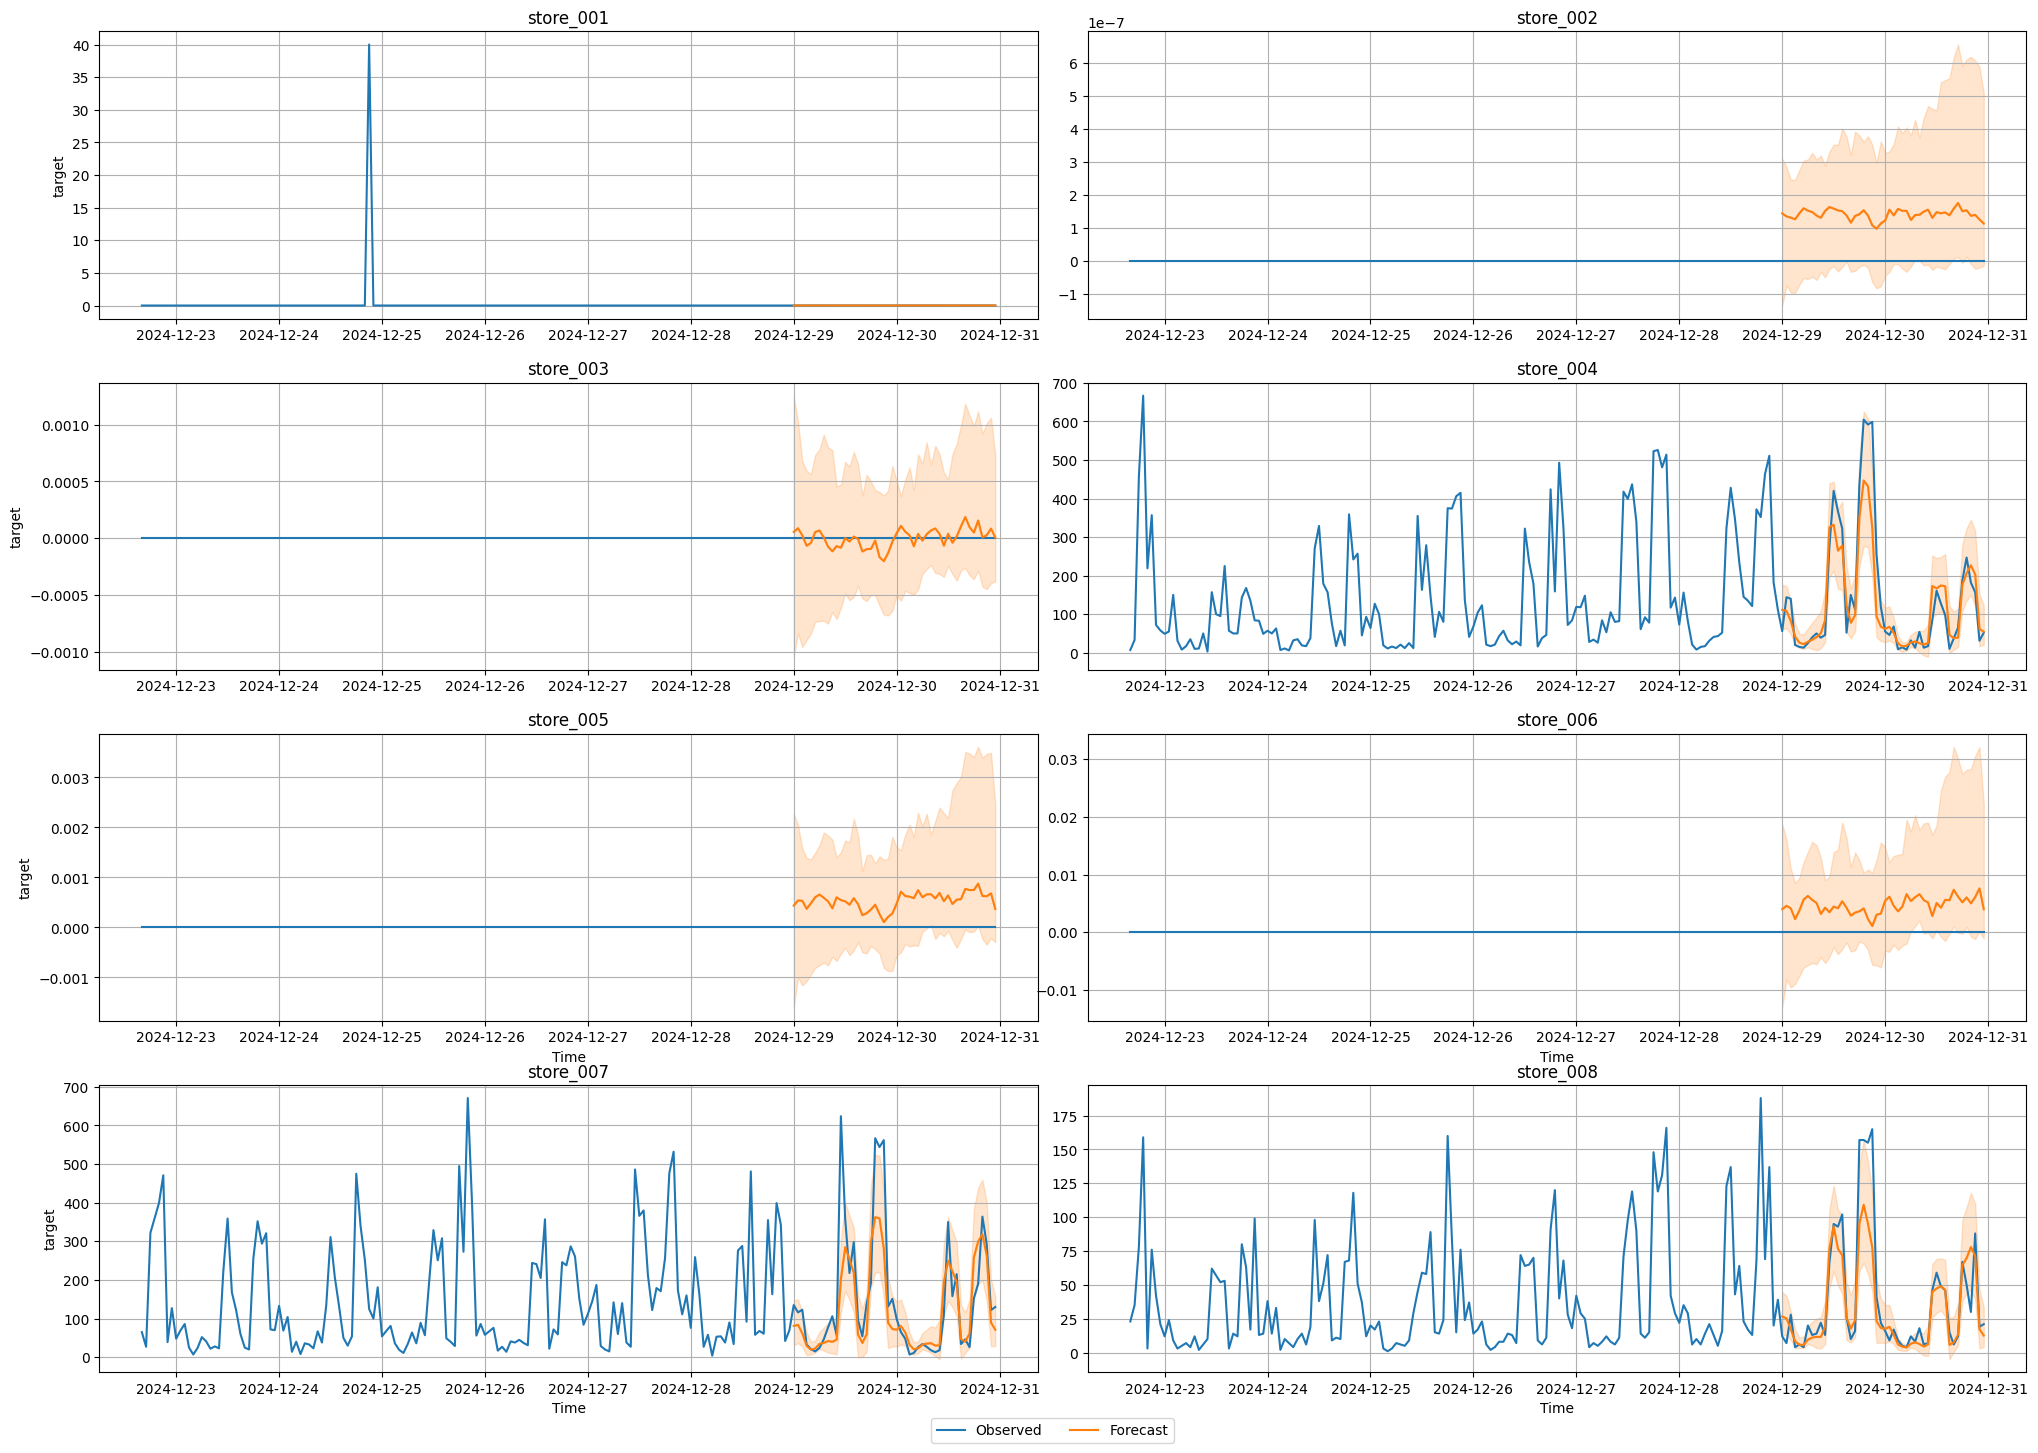

In [6]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    # item_ids=data.item_ids[:2],
    item_ids=data.item_ids,
    max_history_length=200,
);

## Fine-tuning

We have seen above how Chronos models can produce forecasts in zero-shot mode. AutoGluon also makes it easy to fine-tune Chronos models on a specific dataset to maximize the predictive accuracy.

The following snippet specifies two settings for the Chronos-Bolt ️(Small) model: zero-shot and fine-tuned. `TimeSeriesPredictor` will perform a lightweight fine-tuning of the pretrained model on the provided training data. We add name suffixes to easily identify the zero-shot and fine-tuned versions of the model.

In [7]:
import pandas as pd

# Create TimeSeriesDataFrame
import pandas as pd

# Load data
df = pd.read_csv(
    "/Users/sjsj/Documents/order-platform-mlops/order-platform-msa-train-pipeline/data/forecast_data_featured.csv"
)

df = df.rename(columns={"store_id": "item_id"})
df = df.rename(columns={"order_count": "target"})

df = df.sort_values(["item_id", "timestamp"])

# Create TimeSeriesDataFrame
data = TimeSeriesDataFrame.from_data_frame(df)
data.head()

category region  target  sales_amount  \
item_id   timestamp                                                          
store_001 2022-01-01 00:00:00  디저트/케이크/생크림케이크    광진구      15         30008   
          2022-01-01 01:00:00  디저트/케이크/생크림케이크    광진구      11         22542   
          2022-01-01 02:00:00  디저트/케이크/생크림케이크    광진구      20         53162   
          2022-01-01 03:00:00  디저트/케이크/생크림케이크    광진구       1          2765   
          2022-01-01 04:00:00  디저트/케이크/생크림케이크    광진구       3          5926   

                               day_of_week  hour  min_order_amount  \
item_id   timestamp                                                  
store_001 2022-01-01 00:00:00            5     0              1844   
          2022-01-01 01:00:00            5     1              1844   
          2022-01-01 02:00:00            5     2              1844   
          2022-01-01 03:00:00            5     3              1844   
          2022-01-01 04:00:00            5     4              1844   

                               avg_rating  receipt_delivery_ratio  \
item_id   timestamp                                                 
store_001 2022-01-01 00:00:00        4.72                0.697917   
          2022-01-01 01:00:00        4.74                0.683282   
          2022-01-01 02:00:00        4.68                0.664072   
          2022-01-01 03:00:00        4.67                0.703799   
          2022-01-01 04:00:00        4.67                0.721087   

                               receipt_take_out_ratio  \
item_id   timestamp                                     
store_001 2022-01-01 00:00:00                0.251381   
          2022-01-01 01:00:00                0.307185   
          2022-01-01 02:00:00                0.301995   
          2022-01-01 03:00:00                0.306939   
          2022-01-01 04:00:00                0.289364   

                               payment_simple_pay_ratio  \
item_id   timestamp                                       
store_001 2022-01-01 00:00:00                  0.474390   
          2022-01-01 01:00:00                  0.508342   
          2022-01-01 02:00:00                  0.482497   
          2022-01-01 03:00:00                  0.552946   
          2022-01-01 04:00:00                  0.487239   

                               payment_credit_card_ratio  
item_id   timestamp                                       
store_001 2022-01-01 00:00:00                   0.493686  
          2022-01-01 01:00:00                   0.525938  
          2022-01-01 02:00:00                   0.529876  
          2022-01-01 03:00:00                   0.470685  
          2022-01-01 04:00:00                   0.529048

In [8]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {
                "model_path": "bolt_small",
                "fine_tune": True,
                "ag_args": {"name_suffix": "FineTuned"},
            },
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/sjsj/Documents/order-platform-mlops/order-platform-msa-train-pipeline/notebooks/AutogluonModels/ag-20250905_072958'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250904
Python Version:     3.13.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:29:54 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          1
Memory Avail:       3.75 GB / 16.00 GB (23.4%)
Disk Space Avail:   338.72 GB / 460.43 GB (73.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                           

Here we used the default fine-tuning configuration for Chronos by only specifying `"fine_tune": True`. However, AutoGluon makes it easy to change other parameters for fine-tuning such as the number of steps or learning rate.
```python
predictor.fit(
    ...,
    hyperparameters={"Chronos": {"fine_tune": True, "fine_tune_lr": 1e-4, "fine_tune_steps": 2000}},
)
```

For the full list of fine-tuning options, see the Chronos documentation in [Forecasting Model Zoo](forecasting-model-zoo.md#autogluon.timeseries.models.ChronosModel).


After fitting, we can evaluate the two model variants on the test data and generate a leaderboard.

In [9]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.270311,-0.279859,0.462319,0.323112,48.029790,2
1,ChronosZeroShot[bolt_small],-0.278969,-0.286308,1.526044,1.763631,0.121621,1


Fine-tuning resulted in a more accurate model, as shown by the better `score_test` on the test set.

Note that all AutoGluon-TimeSeries models report scores in a "higher is better" format, meaning that most forecasting error metrics like WQL are multiplied by -1 when reported.

In [10]:
predictions_fine_tuned = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions_fine_tuned,
    item_ids=data.item_ids,
    max_history_length=200,
);

Model not specified in predict, will default to the model with the best validation score: ChronosFineTuned[bolt_small]


## Incorporating the covariates

Chronos️ is a univariate model, meaning it relies solely on the historical data of the target time series for making predictions. However, in real-world scenarios, additional exogenous information related to the target series (e.g., holidays, promotions) is often available. Leveraging this information when making predictions can improve forecast accuracy.

AG-TS now features covariate regressors that can be combined with univariate models like Chronos-Bolt to incorporate exogenous information.
A `covariate_regressor` in AG-TS is a tabular regression model that is fit on the known covariates and static features to predict the target column at the each time step. The predictions of the covariate regressor are subtracted from the target column, and the univariate model then forecasts the residuals.

In [16]:
import pandas as pd

# Create TimeSeriesDataFrame
import pandas as pd

# Load data
df = pd.read_csv(
    "/Users/sjsj/Documents/order-platform-mlops/order-platform-msa-train-pipeline/data/forecast_data_featured.csv"
)

# Optional: Sort by item_id and timestamp for optimal performance
# (TimeSeriesDataFrame can handle both orders, but this is more efficient)
df = df.rename(columns={"store_id": "item_id"})
df = df.sort_values(["item_id", "timestamp"])

# Create TimeSeriesDataFrame
data = TimeSeriesDataFrame.from_data_frame(df)
data.head()

category region  order_count  \
item_id   timestamp                                                 
store_001 2022-01-01 00:00:00  디저트/케이크/생크림케이크    광진구           15   
          2022-01-01 01:00:00  디저트/케이크/생크림케이크    광진구           11   
          2022-01-01 02:00:00  디저트/케이크/생크림케이크    광진구           20   
          2022-01-01 03:00:00  디저트/케이크/생크림케이크    광진구            1   
          2022-01-01 04:00:00  디저트/케이크/생크림케이크    광진구            3   

                               sales_amount  day_of_week  hour  \
item_id   timestamp                                              
store_001 2022-01-01 00:00:00         30008            5     0   
          2022-01-01 01:00:00         22542            5     1   
          2022-01-01 02:00:00         53162            5     2   
          2022-01-01 03:00:00          2765            5     3   
          2022-01-01 04:00:00          5926            5     4   

                               min_order_amount  avg_rating  \
item_id   timestamp                                           
store_001 2022-01-01 00:00:00              1844        4.72   
          2022-01-01 01:00:00              1844        4.74   
          2022-01-01 02:00:00              1844        4.68   
          2022-01-01 03:00:00              1844        4.67   
          2022-01-01 04:00:00              1844        4.67   

                               receipt_delivery_ratio  receipt_take_out_ratio  \
item_id   timestamp                                                             
store_001 2022-01-01 00:00:00                0.697917                0.251381   
          2022-01-01 01:00:00                0.683282                0.307185   
          2022-01-01 02:00:00                0.664072                0.301995   
          2022-01-01 03:00:00                0.703799                0.306939   
          2022-01-01 04:00:00                0.721087                0.289364   

                               payment_simple_pay_ratio  \
item_id   timestamp                                       
store_001 2022-01-01 00:00:00                  0.474390   
          2022-01-01 01:00:00                  0.508342   
          2022-01-01 02:00:00                  0.482497   
          2022-01-01 03:00:00                  0.552946   
          2022-01-01 04:00:00                  0.487239   

                               payment_credit_card_ratio  
item_id   timestamp                                       
store_001 2022-01-01 00:00:00                   0.493686  
          2022-01-01 01:00:00                   0.525938  
          2022-01-01 02:00:00                   0.529876  
          2022-01-01 03:00:00                   0.470685  
          2022-01-01 04:00:00                   0.529048

We use the local forecast data to demonstrate how Chronos-Bolt can be combined with a covariate regressor. This dataset includes several covariates such as `category`, `region`, `sales_amount`, `day_of_week`, `hour`, and others that can help improve forecasting accuracy for `order_count`.

In [17]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

The following code fits a TimeSeriesPredictor to forecast `order_count` for the next 48 hours.

Note that we have specified the target column we are interested in forecasting and the names of known covariates while constructing the TimeSeriesPredictor.

We define two configurations for Chronos-Bolt:
- zero-shot configuration that uses only the historical values of `order_count` without considering the covariates;
- a configuration with a CatBoost regression model as the `covariate_regressor`. Note that we recommend to apply a `target_scaler` when using a covariate regressor. Target scaler ensures that all time series have comparable scales, often leading to better accuracy.

Like before, we add suffixes to model names to more easily distinguish them in the leaderboard.

In [18]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="order_count",
    known_covariates_names=[
        "category",
        "region",
        "day_of_week",
        "hour",
        "min_order_amount",
        "avg_rating",
    ],
).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/sjsj/Documents/order-platform-mlops/order-platform-msa-train-pipeline/notebooks/AutogluonModels/ag-20250905_073148'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250904
Python Version:     3.13.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.6.0: Mon Jul 14 11:29:54 PDT 2025; root:xnu-11417.140.69~1/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          1
Memory Avail:       3.02 GB / 16.00 GB (18.9%)
Disk Space Avail:   338.47 GB / 460.43 GB (73.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
            

Once the predictor has been fit, we can evaluate it on the test dataset and generate the leaderboard. We see that the model that utilizes the covariates produces a more accurate forecast on the test set.

In [19]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosWithRegressor[bolt_small],-0.275511,-0.287136,2.139302,1.726389,14.681692,2
1,ChronosZeroShot[bolt_small],-0.278969,-0.286308,1.309386,1.768586,0.103542,1


In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids,
    max_history_length=200,
);

Note that the covariates may not always be useful — for some datasets, the zero-shot model may achieve better accuracy. Therefore, it's always important to try out multiple models and select the one that achieves the best accuracy on held-out data. This is done automatically in AutoGluon's `"high_quality"` and `"best_quality"` presets.